In [5]:
# !mamba install xarray-datatree -y
# !mamba install "xmip>=0.7.1" -y
# !pip install "xmip>=0.7.1"

In [9]:
from distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 58.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42261,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 58.87 GiB
Comm: tcp://127.0.0.1:35747,Total threads: 4
Dashboard: /user/jbusecke/proxy/35253/status,Memory: 14.72 GiB
Nanny: tcp://127.0.0.1:41911,


In [3]:
import time
tic = time.time()

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col

from xarrayutils.plotting import shaded_line_plot
xr.set_options(keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (10,5)

In [23]:
col = google_cmip_col()
query = dict(
    source_id = [
     'IPSL-CM6A-LR',
     'MPI-ESM1-2-LR',
     'GFDL-ESM4',
     'EC-Earth3',
     'CMCC-ESM2',
     'CESM2',
    ],
    experiment_id = ['historical','ssp126', 'ssp370', 'ssp245', 'ssp585'],
    grid_label='gn',
)
cat = col.search(
    **query,
    variable_id='tos',
    member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1','r4i1p1f1', 'r5i1p1f1'], #
    table_id='Omon'
)
kwargs = dict(preprocess=combined_preprocessing, xarray_open_kwargs=dict(use_cftime=True), aggregate=False)
ddict = cat.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [24]:
cat_area = col.search(
    **query,
    table_id='Ofx',
    variable_id='areacello',
)
ddict_area = cat_area.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [25]:
from xmip.postprocessing import match_metrics
ddict_w_area = match_metrics(ddict, ddict_area, 'areacello', print_statistics=True) 

Processed 85 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 85}
No match found:{'areacello': 0}


In [26]:
from xmip.postprocessing import concat_members

import dask
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ddict_combined_members = concat_members(ddict_w_area)

## xarray-datatree

In [27]:
from datatree import DataTree

# create a path: dataset dictionary, where the path is based on each datasets attributes
tree_dict = {f"{ds.source_id}/{ds.experiment_id}/":ds for ds in ddict_combined_members.values()}

dt = DataTree.from_dict(tree_dict)
dt

DataTree('None', parent=None)
├── DataTree('EC-Earth3')
│   ├── DataTree('ssp585')
│   │       Dimensions:         (member_id: 3, dcpp_init_year: 1, time: 1032, y: 292,
│   │                            x: 362, vertex: 4, bnds: 2)
│   │       Coordinates: (12/13)
│   │           lat             (y, x) float64 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
│   │           lon             (y, x) float64 72.5 73.5 74.5 75.5 ... 73.04 73.0 72.99
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           lat_verticies   (member_id, y, x, vertex) float64 dask.array<chunksize=(1, 292, 362, 4), meta=np.ndarray>
│   │           lon_verticies   (member_id, y, x, vertex) float64 dask.array<chunksize=(1, 292, 362, 4), meta=np.ndarray>
│   │           time_bounds     (time, bnds) object 2015-01-01 00:00:00 ... 2101-01-01 00...
│   │           ...              ...
│   │         * x               (x) int64 0 1 2 3 4 5 6 7 ... 355 356 357 358 359 360 361
│   │           lon_bounds      (member_id, bnds, y, x) float64 dask.array<chunksize=(1, 1, 292, 362), meta=np.ndarray>
│   │           lat_bounds      (member_id, bnds, y, x) float64 dask.array<chunksize=(1, 1, 292, 362), meta=np.ndarray>
│   │         * member_id       (member_id) object 'r1i1p1f1' 'r3i1p1f1' 'r4i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │           areacello       (member_id, dcpp_init_year, y, x) float32 dask.array<chunksize=(1, 1, 292, 362), meta=np.ndarray>
│   │       Dimensions without coordinates: vertex, bnds
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 134, 292, 362), meta=np.ndarray>
│   │       Attributes: (12/46)
│   │           Conventions:                        CF-1.7 CMIP-6.2
│   │           activity_id:                        ScenarioMIP
│   │           branch_method:                      standard
│   │           branch_time:                        0.0
│   │           comment:                            Production: Thomas Reerink at KNMI
│   │           contact:                            cmip6-data@ec-earth.org
│   │           ...                                 ...
│   │           intake_esm_attrs:experiment_id:     ssp585
│   │           intake_esm_attrs:table_id:          Omon
│   │           intake_esm_attrs:variable_id:       tos
│   │           intake_esm_attrs:grid_label:        gn
│   │           intake_esm_attrs:_data_format_:     zarr
│   │           NCO:                                netCDF Operators version 4.9.2 (Homep...
│   ├── DataTree('historical')
│   │       Dimensions:         (member_id: 4, dcpp_init_year: 1, time: 1980, y: 292,
│   │                            x: 362, vertex: 4, bnds: 2)
│   │       Coordinates: (12/13)
│   │           lat             (y, x) float64 -78.39 -78.39 -78.39 ... 50.23 50.01 50.01
│   │           lon             (member_id, y, x) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           lat_verticies   (member_id, y, x, vertex) float64 dask.array<chunksize=(1, 292, 362, 4), meta=np.ndarray>
│   │           lon_verticies   (member_id, y, x, vertex) float64 dask.array<chunksize=(1, 292, 362, 4), meta=np.ndarray>
│   │           time_bounds     (time, bnds) object 1850-01-01 00:00:00 ... 2015-01-01 00...
│   │           ...              ...
│   │         * x               (x) int64 0 1 2 3 4 5 6 7 ... 355 356 357 358 359 360 361
│   │           lon_bounds      (member_id, bnds, y, x) float64 dask.array<chunksize=(1, 1, 292, 362), meta=np.ndarray>
│   │           lat_bounds      (member_id, bnds, y, x) float64 dask.array<chunksize=(1, 1, 292, 362), meta=np.ndarray>
│   │         * member_id       (member_id) object 'r1i1p1f1' 'r2i1p1f1' ... 'r4i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │           areacello       

In [28]:
dt.nbytes / 1e9  # size in GB

58.375136776

In [29]:
# find a single member that is in all 3 scenarios
dt_single_member = DataTree()
for model_name, model in dt.children.items():
    member_id_values = []
    has_no_area = 0
    for experiment_name, experiment in model.children.items():
        ds = experiment.ds
        # print(ds)
        if 'areacello' in ds:
            member_id_values.append(set(ds.member_id.data))  
        else:
            has_no_area += 1
    
    if has_no_area == 0:
        # find the intersection of all values
        # print(member_id_values)
        full_members = set(member_id_values[0]).intersection(*member_id_values)
        if len(full_members)>0:
            # sort and take the first one
            pick_member = sorted(full_members)[0]
            dt_single_member[model_name] = model.sel(member_id=pick_member)
        else:
            print(f"{model_name} did not have a single member that is in all experiments")
    else:
        print(f"Not all experiments for {model_name} have area coords. Skipping")

In [30]:
# average temperature globally
def global_mean_sst(ds):
    return ds.tos.weighted(
        ds.areacello.fillna(0)
    ).mean(
        ['x', 'y']
    ).persist() 

timeseries = dt_single_member.map_over_subtree(global_mean_sst)
timeseries

DataTree('None', parent=None)
├── DataTree('EC-Earth3')
│   ├── DataTree('ssp585')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 134), meta=np.ndarray>
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 134), meta=np.ndarray>
│   ├── DataTree('ssp126')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 134), meta=np.ndarray>
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 134), meta=np.ndarray>
│   └── DataTree('ssp370')
│           Dimensions:         (time: 1032, dcpp_init_year: 1)
│           Coordinates:
│             * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│               member_id       <U8 'r1i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 nan
│           Data variables:
│               tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 134), meta=np.ndarray>
├── DataTree('IPSL-CM6A-LR')
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 120), meta=np.ndarray>
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 251), meta=np.ndarray>
│   ├── DataTree('ssp370')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (dcpp_init_year, time) float32 dask.array<chunksize=(1, 250), meta=np.ndarray>
│   ├── DataTree('ssp585')
│   │       Dimensions:         (time: 1032, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           member_id       <U8 'r1i1p1f1'
│   │         * dcpp_init_year

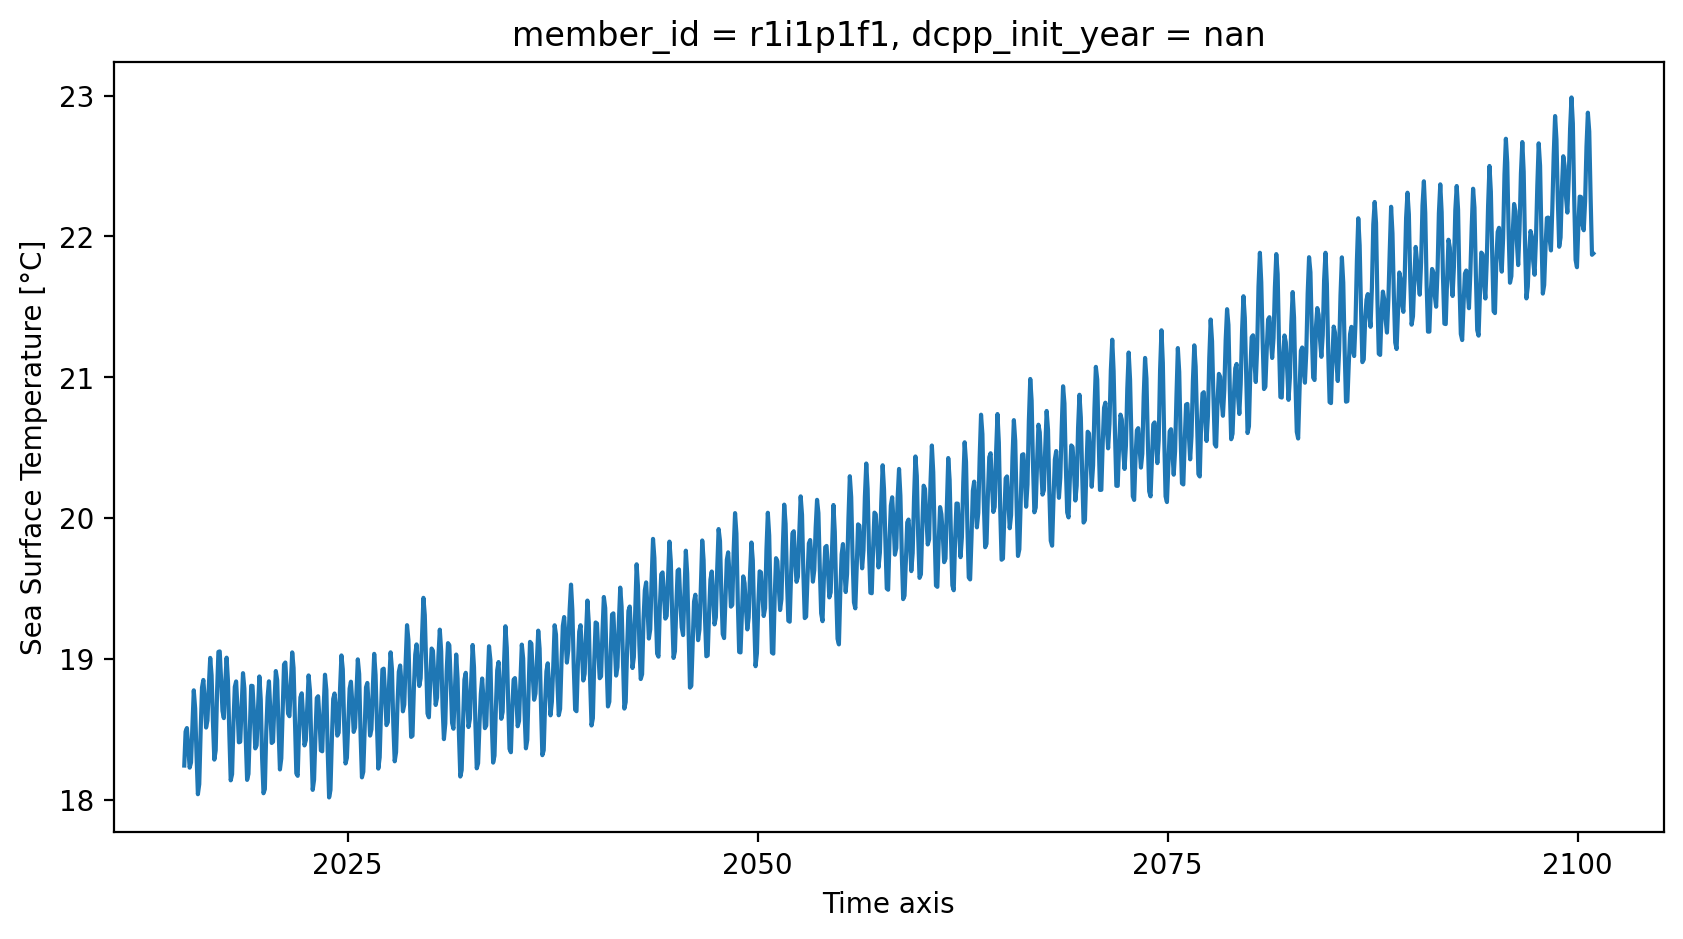

In [31]:
timeseries['/IPSL-CM6A-LR/ssp585'].ds['tos'].plot()

In [32]:
anomaly = DataTree()

def get_ref_value(ds):
    return ds.sel(time=slice('1950','1980')).mean('time')

for model_name, model in timeseries.children.items():
    if 'historical' in model:
        # model-specific base period
        base_period = get_ref_value(model["historical"].ds)
        anomaly[model_name] = model - base_period   # subtree - Dataset
    else:
        print(f"No historical run found for {model_name}")

In [33]:
experiment_dict = {k:[] for k in ['historical','ssp126', 'ssp370', 'ssp245', 'ssp585']}

for model_name, model in anomaly.children.items():
    for experiment_name, experiment in model.children.items():
        ds = experiment.ds
        # replace the time dimension
        start_date = ds.time.data[0]
        new_time = xr.cftime_range(f"{start_date.year}-{start_date.month:02}", freq='1MS', periods=len(ds.time))
        ds_new_cal = ds.assign_coords(time=new_time, source_id=model_name)
        ds_new_cal = ds_new_cal.load()
        
        experiment_dict[experiment_name].append(ds_new_cal)

# concatenate all models for a given experiment
plot_dict = {k:xr.concat(ds_lst, dim='source_id') for k, ds_lst in experiment_dict.items()}

In [34]:
# add observations
store = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr'
ds_obs = xr.open_dataset(store, engine='zarr', chunks={}).rename({'sst':'tos'}).convert_calendar('standard', use_cftime=True)
ds_obs = ds_obs.where(abs(ds_obs.tos)<50)
area = np.cos(np.deg2rad(ds_obs.latitude)) * 110e3 **2
ds_obs_ts = ds_obs.weighted(area).mean(['longitude', 'latitude'])
ds_obs_anomaly = ds_obs_ts - get_ref_value(ds_obs_ts)

# add to plot_dict
plot_dict['observations'] = ds_obs_anomaly.expand_dims(['source_id', 'dcpp_init_year']).load()

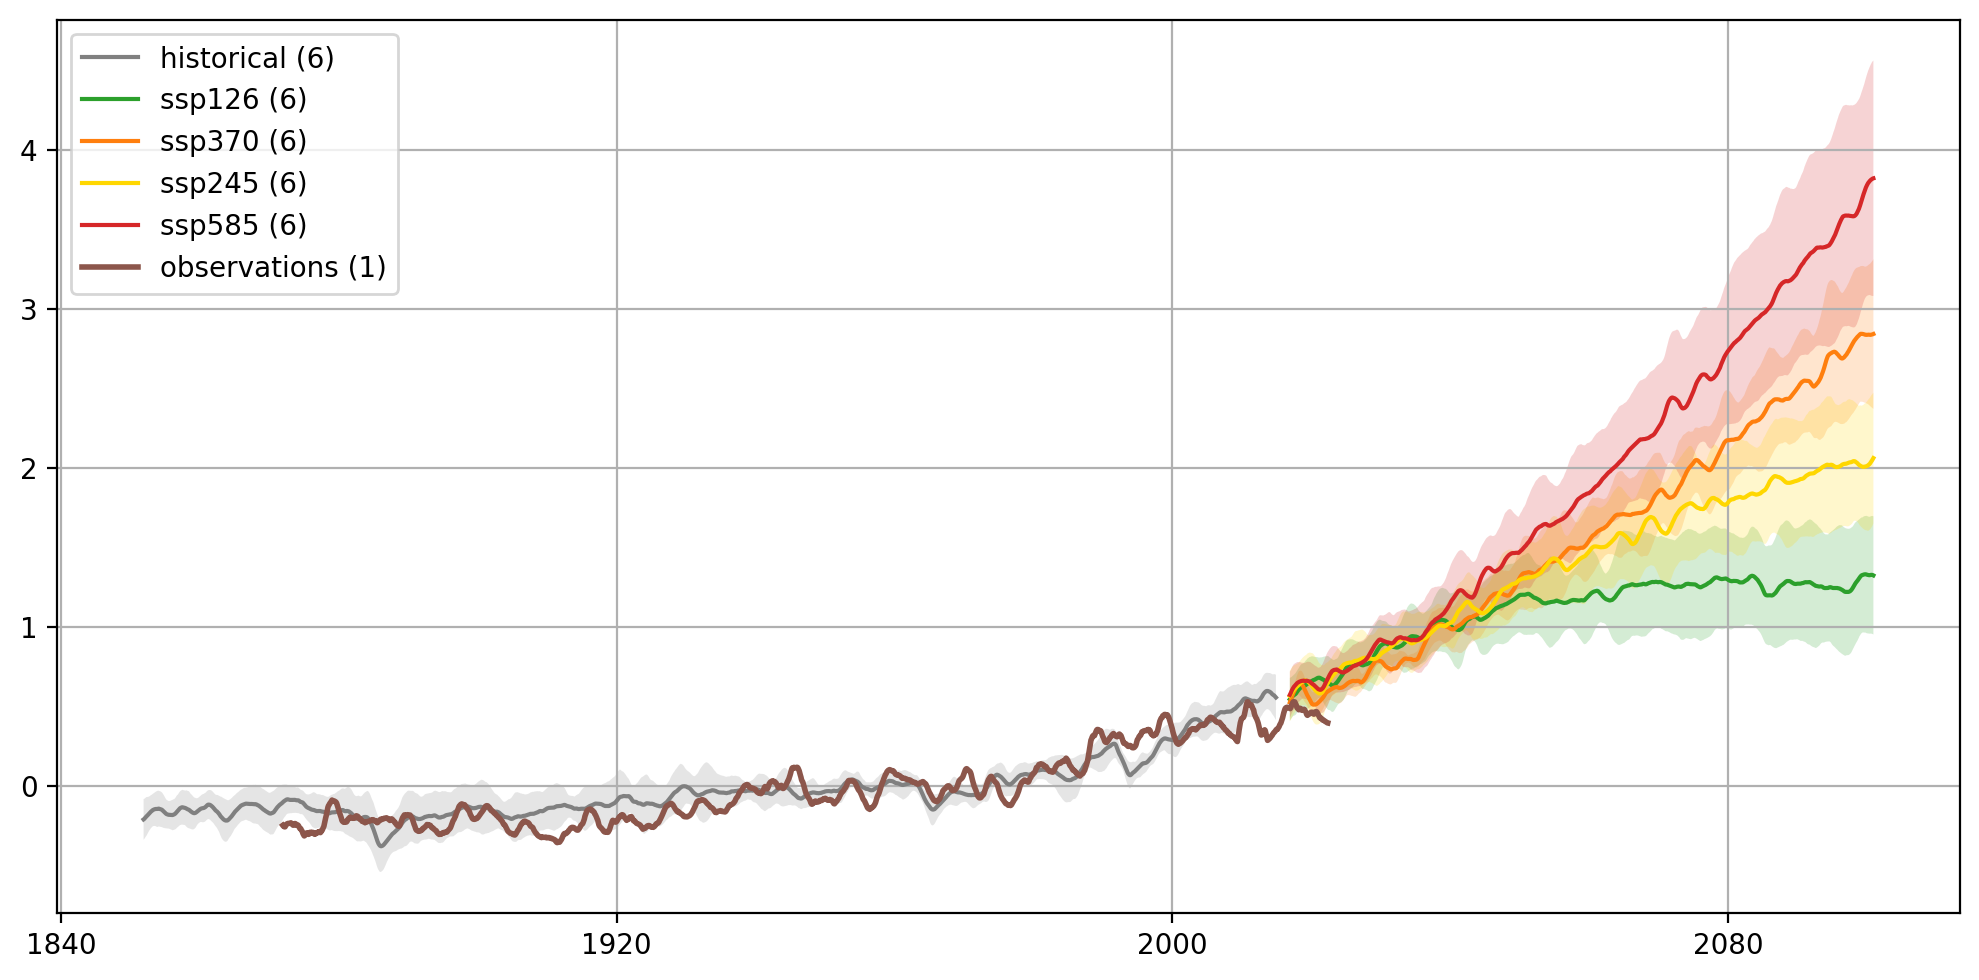

In [42]:
fig, ax = plt.subplots()

color_dict = {
    'historical':'0.5',
    'ssp126': 'C2',
    'ssp245': 'gold',
    'ssp370': 'C1',
    'ssp585': 'C3',
    'observations': 'C5'
}
for experiment, ds in plot_dict.items():
    color = color_dict[experiment]
    smooth = ds['tos'].sel(time=slice(None, '2100')).rolling(time=2*12).mean().squeeze('dcpp_init_year')
    lw = 2 if experiment=='observations' else 1.5
    shaded_line_plot(smooth, 'source_id', ax=ax, spreads=[2.0], alphas=[0.2], line_kwargs=dict(color=color, label=f"{experiment} ({len(ds.source_id)})", lw=lw))
plt.legend(loc=2);
plt.grid()
plt.tight_layout()

In [19]:
toc = time.time()
print(f"Elapsed time: {int(toc-tic)} seconds")

Elapsed time: 176 seconds
